<a href="https://colab.research.google.com/github/devadathprabhu/DSC612/blob/main/TheoryAssignment_Model2_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [5]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import cv2
import random

import tensorflow as tf
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import add
from keras.layers import Activation
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import multiply
from keras.layers import concatenate

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [39]:
path = "/content/gdrive/MyDrive/Kaggle/lgg-mri-segmentation/kaggle_3m/"
masks_dir = glob(path + "*/*_mask*")

images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })

In [40]:
ROWS = 32
COLS = 32
CHANNELS = 3

In [41]:
def read_image(file_path):
  #print(file_path)
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  #print(img)
  return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [43]:
all_imgs = masks_dir + images_dir

In [44]:
def prep_data(images):
  m = len(images)
  n_x = ROWS*COLS*CHANNELS
  X = np.ndarray((m,ROWS,COLS,CHANNELS), dtype=np.uint8)
  y = np.zeros((m,1))
  print("X.shape is {}".format(X.shape))
  for i,image_file in enumerate(images) :
    image = read_image(image_file)
    X[i,:] = np.squeeze(image.reshape((ROWS, COLS, CHANNELS)))
    if 'mask' in image_file.lower() :
      y[i,0] = 1
    else :
      y[i,0] = 0
  return X,y

In [45]:
x_train, y_train = prep_data(all_imgs)

X.shape is (7858, 32, 32, 3)


In [46]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=.4)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.2)
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)
#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((3771, 32, 32, 3), (3771, 2))
((943, 32, 32, 3), (943, 2))
((3144, 32, 32, 3), (3144, 2))


In [47]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rotation_range=2, 
                                     horizontal_flip=True,zoom_range=.1 )
val_generator = ImageDataGenerator(rotation_range=2, 
                                   horizontal_flip=True,zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, 
                                    horizontal_flip= True,zoom_range=.1)
#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np

np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96,input_shape=(32,32,3),kernel_size=(11,11),
                   strides=(4,4),padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 96)         384       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_10 (Bat  (None, 4, 4, 256)       

In [53]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy,
                optimizer= 'adam', metrics=['accuracy'])

In [54]:
from keras.callbacks import ReduceLROnPlateau
lrr=ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)
#Defining the parameters
batch_size=64
epochs=10
learn_rate=.001

In [55]:
AlexNet.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size),
     epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,
      validation_data = (x_val, y_val),
       validation_steps = 10, callbacks = [lrr], verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
58/58 [==============================] - 66s 1s/step - loss: 0.1406 - accuracy: 0.9771 - val_loss: 1.0845 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 2/10
58/58 [==============================] - 63s 1s/step - loss: 0.1212 - accuracy: 0.9814 - val_loss: 0.2781 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 3/10
58/58 [==============================] - 63s 1s/step - loss: 0.0923 - accuracy: 0.9957 - val_loss: 0.4718 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 4/10
58/58 [==============================] - 63s 1s/step - loss: 0.0799 - accuracy: 0.9987 - val_loss: 0.1311 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/10
58/58 [==============================] - 63s 1s/step - loss: 0.0741 - accuracy: 0.9978 - val_loss: 0.2191 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 6/10
58/58 [==============================] - 64s 1s/step - loss: 0.0668 - accuracy: 0.9984 - val_loss: 0.1183 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 7/10
58/58 [==============================] - 63s 1s/step - loss: 0.0608 - a

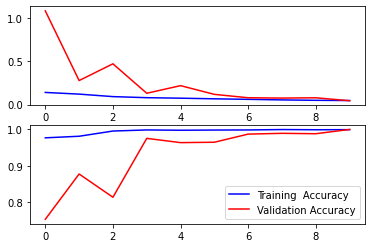

In [56]:
import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()